# Squeezed Lasing: phase-diffused stationary state

In [2]:
import math as math
import numpy as np
import scipy as scipy
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import matplotlib.animation as animation
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import sys
import os

from qutip import *
from src_2_0 import *

In [3]:
def H_def(a_s,sigma,delta_s,delta_sigma,g_0,r): # Defines the Hamiltonian of the system. It considers a coupling between a photonic cavity and a one-atom subsystem.
    return delta_s*a_s*a_s.dag()+delta_sigma*sigma.dag()*sigma+g_0*np.cosh(r)*(a_s.dag()*sigma+a_s*sigma.dag())

In [4]:
def Lops_def(a_s,sigma,k,P,eta): # Defines the system's collapse (Lindblad) operators, one that represents incoherent pumping and other that describes photon loss.
    return [np.sqrt(P)*sigma.dag(),np.sqrt(k*(1+eta))*a_s]

#### Parameters

In [5]:
### General parameters ###

N = 500 # Dimension of the Hilbert space of the cavity
n_q = 100 # Photon saturation number
C = np.linspace(1e-15,2,30) # Cooperativity (equal to the pumping parameter p)
eta = 0 # Photon loss due to other decay channels
delta_c = 0.05 # Detuning w_c-w_p
k = 0.0014 # Photon decay rate

### Squeezed parameters ###

r = 0.75 # Squeezing parameter
theta = np.pi # Squeezing angle

### Symmetry broken parameters ###

omega = 0 # Amplitude of the coherent driving with well defined phase
phi = 0 # Fixed phase

#### Parameter-dependent quantities

In [6]:
g_0 = k*np.sqrt((C*n_q)/2) # Light-matter coupling
P = 2*n_q*k # Incoherent pumping
alpha = (np.e**(4*r)-1)/(np.e**(4*r)+1) # omega_p/delta_c
omega_p = alpha*delta_c # Amplitude of the coherent drive (down-conversion)
delta_s = delta_c*np.sqrt(1-(omega_p/delta_c)**2) # Detuning in the squeezed basis
delta_sigma = delta_s # Detuning w_sigma-w_p (the same as delta_s to apply RWA)
C_s = C*np.cosh(r)**2 # Squeezed cooperativity (equal to the squeezed pumping parameter p_s)

Check RWA conditions

In [8]:
print(delta_c,delta_s,delta_sigma,g_0*np.sinh(r))

0.05 0.021254801747114027 0.021254801747114027 [2.57425856e-10 2.13780537e-03 3.02331335e-03 3.70278752e-03
 4.27561074e-03 4.78027813e-03 5.23653233e-03 5.65610136e-03
 6.04662670e-03 6.41341611e-03 6.76033417e-03 7.09029829e-03
 7.40557504e-03 7.70796688e-03 7.99893526e-03 8.27968460e-03
 8.55122148e-03 8.81439735e-03 9.06994005e-03 9.31847757e-03
 9.56055626e-03 9.79665493e-03 1.00271960e-02 1.02525544e-02
 1.04730647e-02 1.06890269e-02 1.09007113e-02 1.11083626e-02
 1.13122027e-02 1.15124342e-02]


In [9]:
aux = 1

if delta_sigma > aux*g_0[-1]*np.sinh(r):
    if delta_s > aux*g_0[-1]*np.sinh(r):
        print('double check')
    else:
        print('Check values of delta_c')
else:
    print('Check value of r')

double check


#### Operators

In [11]:
a_s = tensor(destroy(N),identity(2)) # Annihilation operator of the squeezed basis
a = a_s*np.cosh(r)-np.exp(-1j*theta)*a_s.dag()*np.sinh(r) # Annihilation operator of the bare basis
sigma = tensor(identity(N),basis(2,0)*basis(2,1).dag()) # Lowering operator of the two-level system
S = (0.5*(r*np.exp(-1j*theta)*a_s*a_s-np.conj(r*np.exp(-1j*theta))*a_s.dag()*a_s.dag())).expm() # Squeezing operator

### 5. Emission spectrum $S(\omega)$

In [13]:
N_spec = 80 # We reduce the dimension of the Hilbert space for faster computation
a_s_spec = tensor(destroy(N_spec),identity(2)) # Redefinition of the annihilation operator in the squeezed basis
a_spec = a_s_spec*np.cosh(r)-np.exp(-1j*theta)*a_s_spec.dag()*np.sinh(r) # Annihilation operator of the bare basis
sigma_spec = tensor(identity(N_spec),basis(2,0)*basis(2,1).dag()) # Redefinition of the lowering operator of the two-level system
#k_spec = k[index] # Chosen decay and pumping parameters for the following calculations
#P_spec = P[index]

In [30]:
spec = np.zeros([2000,np.size(C)-8])
wlist = np.zeros([2000,np.size(C)-8])
for i in tqdm(range(np.size(C)-8)):
        wlist[:,i], spec[:,i] = spec_prop(a_spec,H_def(a_s_spec,sigma_spec,delta_s,delta_sigma,g_0[i+1],r),Lops_def(a_s_spec,sigma_spec,k,P,eta)).emis_spec(k,tau_f=100)

100%|██████████| 22/22 [5:46:15<00:00, 944.34s/it]   


In [31]:
spec2 = np.zeros([2000,np.size(C)-8])
wlist2 = np.zeros([2000,np.size(C)-8])
for i in tqdm(range(np.size(C)-8)):
        wlist2[:,i] = wlist[:,i]/k
        spec2[:,i] = spec[:,i]/np.max(spec[:,i])

100%|██████████| 22/22 [00:00<00:00, 5518.16it/s]


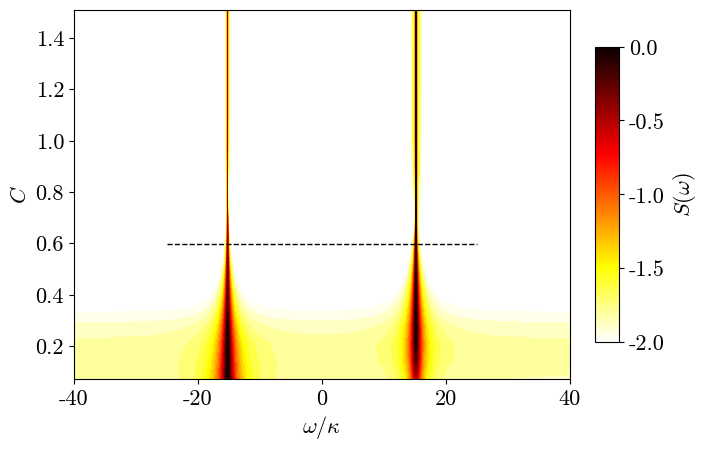

In [36]:
nrm = mpl.colors.Normalize(-2,0) # Colorbar settings

fig, ax = plt.subplots()

cbar = plt.colorbar(cm.ScalarMappable(norm=nrm, cmap=cm.hot_r), label=r'$S(\omega)$', cax = ax.inset_axes([1.05, 0.1, 0.05, 0.8]))
ax.contourf(wlist2[:,0], C[1:23], np.log10(np.transpose(np.abs(spec2))), 100, cmap=cm.hot_r, norm=nrm)
ax.contourf(wlist2[:,0], C[1:23], np.log10(np.transpose(np.abs(spec2))), 100, cmap=cm.hot_r, norm=nrm)
ax.plot([-25,25],[np.cosh(r)**-2,np.cosh(r)**-2],'--',lw=1,color='k')
ax.set_ylabel(r'$C$')
ax.set_xlabel(r'$\omega/\kappa$')
ax.set_xlim([-40,40])
ax.set_ylim([0.07,1.51])

plt.show()

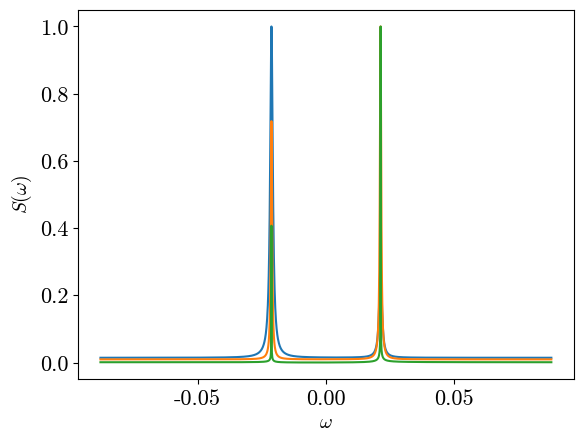

In [35]:
plt.plot(wlist[:,0],np.real(spec2[:,0]))
plt.plot(wlist[:,4],np.real(spec2[:,4]))
plt.plot(wlist[:,21],np.abs(spec2[:,21]))
# plt.title('freq. spectrum',fontsize=14)
plt.xlabel('$\omega$',fontsize=14)
plt.ylabel('$S(\omega)$',fontsize=14)
#plt.xlim([-0.1,0.1])
plt.show()

In [38]:
esp = np.column_stack([wlist2[:,0], spec2])
np.savetxt('.\SEC_VI_A/SPEC'+str(format(r,'.2f'))+'_'+str(format(n_q,'.0f'))+'.txt',esp)